In [2]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib


%pylab inline

Populating the interactive namespace from numpy and matplotlib


## An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.

### So let's test if the last link holds. If we have data on the energy consumed by a building how well does that relate to the number of units in the building?

In [3]:
nrg=pd.read_csv(os.getenv("PUIDATA")+'/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv')


In [4]:
PUIdata=os.getenv("PUIDATA")
if not os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
    print('Downloading...')
    os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip')
    os.system('mv nyc_pluto_16v2%20.zip ' + PUIdata)
    os.system('unzip ' + PUIdata + '/nyc_pluto_16v2%20.zip -d ' + PUIdata)
    if os.path.isfile(PUIdata + "/BORO_zip_files_csv/MN.csv"):
        print('File in place, proceed!')
else:
    print('File in place, proceed!')

File in place, proceed!


In [5]:
bsize=pd.read_csv(PUIdata + "/BORO_zip_files_csv/MN.csv")

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Reading in the Pluto data for manhattan, which will give me the number of units ber building Manhattan/MNMapPLUTO.shp

In [6]:
bsize.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,MN,1,10,101,5.0,1018.0,2.0,1.0,10004.0,E007,...,190225.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
1,MN,1,101,101,1.0,1001.0,2.0,1.0,10004.0,E007,...,190636.0,16a,Y,199 999,10101.0,NaN,0.0,NaN,1,16V2
2,MN,1,201,101,1.0,1000.0,2.0,1.0,10004.0,E007,...,193648.0,12b,NaN,199 999,10101.0,NaN,0.0,NaN,1,16V2
3,MN,1,301,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,199 999,10101.0,NaN,0.0,NaN,4,16V2
4,MN,1,401,101,NaN,NaN,2.0,1.0,10004.0,E007,...,NaN,12b,NaN,1 99 999,10101.0,NaN,0.0,NaN,4,16V2


In [7]:
nrg_new=nrg.drop(['Record Number', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough',
       'DOF Benchmarking Submission Status',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Primary Property Type - Self Selected',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],axis=1)

In [8]:
nrg_new.head()

,BBL,Postcode,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings
0,1.000410e+09,NaN,NaN,918919,NaN,NaN
1,4.021460e+09,11375.0,NaN,NaN,82730.0,1.0
2,2.027620e+09,NaN,NaN,64200,NaN,NaN
3,1.006700e+09,10001.0,NaN,NaN,440360.0,1.0
4,2.048300e+09,NaN,NaN,50000,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f231856cd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f22e0eab748>]], dtype=object)

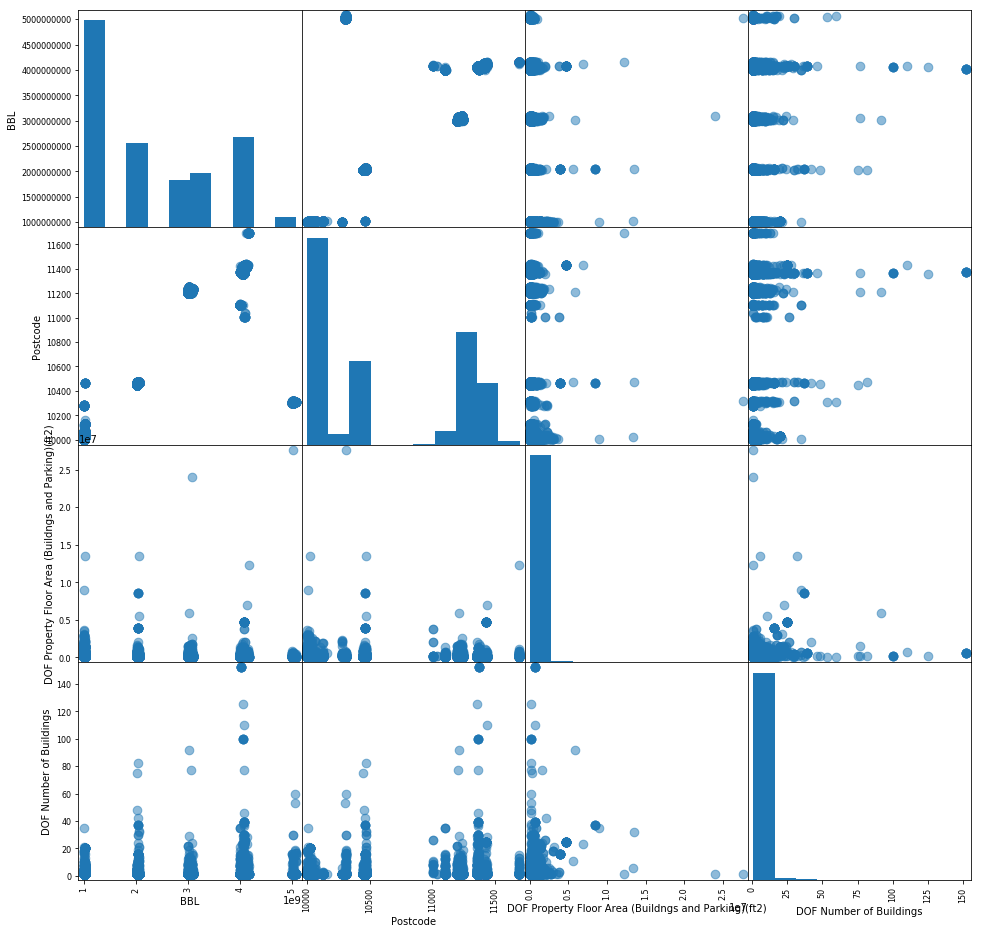

In [9]:
#try make a scatter plot of nrg. Few columns will plot
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg_new, s=300, figsize=(16, 16))

In [10]:
bsize_new=bsize.drop(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistrict', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord', 'ZoneMap', 'ZMCode',
       'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL', 'APPDate', 'PLUTOMapID',
       'Version'],axis=1)

In [11]:
bsize_new.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL
0,0,0,1900,1.000010e+09
1,0,0,1900,1.000010e+09
2,0,0,1900,1.000010e+09
3,0,0,0,1.000010e+09
4,0,0,0,1.000010e+09


In [12]:
nrg_new['Site EUI(kBtu/ft2)']=pd.to_numeric(nrg_new['Site EUI(kBtu/ft2)'],errors='coerce')

In [13]:
nrg_new['BBL']=pd.to_numeric(nrg_new['BBL'],errors='coerce')

In [14]:
nrg_new['Reported Property Floor Area (Building(s)) (ft²)']=pd.to_numeric(nrg_new['Reported Property Floor Area (Building(s)) (ft²)'],errors='coerce')

In [15]:
#How many missing values?
indx = np.isnan(nrg_new['Reported Property Floor Area (Building(s)) (ft²)']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

invalid entries changed to NaN 3125


In [16]:
mergedata=nrg_new.merge(bsize_new,on='BBL')

In [17]:
mergedata.dropna()
mergedata.shape

(6536, 9)

In [18]:
mergedata.head()

,BBL,Postcode,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,10001.0,NaN,NaN,440360.0,1.0,0,1,1987
1,1.004370e+09,10009.0,NaN,NaN,52390.0,1.0,0,4,1920
2,1.013110e+09,10022.0,125.4,330000.0,313200.0,1.0,0,56,1977
3,1.009220e+09,10003.0,NaN,NaN,98260.0,1.0,148,148,1963
4,1.007400e+09,NaN,NaN,68329.0,NaN,NaN,0,1,1920


In [19]:
mergedata=mergedata.drop(['Postcode','DOF Number of Buildings'],axis=1)

mergedata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,440360.0,0,1,1987
1,1.004370e+09,NaN,NaN,52390.0,0,4,1920
2,1.013110e+09,125.4,330000.0,313200.0,0,56,1977
3,1.009220e+09,NaN,NaN,98260.0,148,148,1963
4,1.007400e+09,NaN,68329.0,NaN,0,1,1920


In [20]:
mergedata.columns=['BBL','SiteEUI','AreaReported','DOFfloorArea','UnitsRes','UnitsTotal','YearBuilt']
mergedata.head()

,BBL,SiteEUI,AreaReported,DOFfloorArea,UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,440360.0,0,1,1987
1,1.004370e+09,NaN,NaN,52390.0,0,4,1920
2,1.013110e+09,125.4,330000.0,313200.0,0,56,1977
3,1.009220e+09,NaN,NaN,98260.0,148,148,1963
4,1.007400e+09,NaN,68329.0,NaN,0,1,1920


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22e033e358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f22d9d9f978>]], dtype=object)

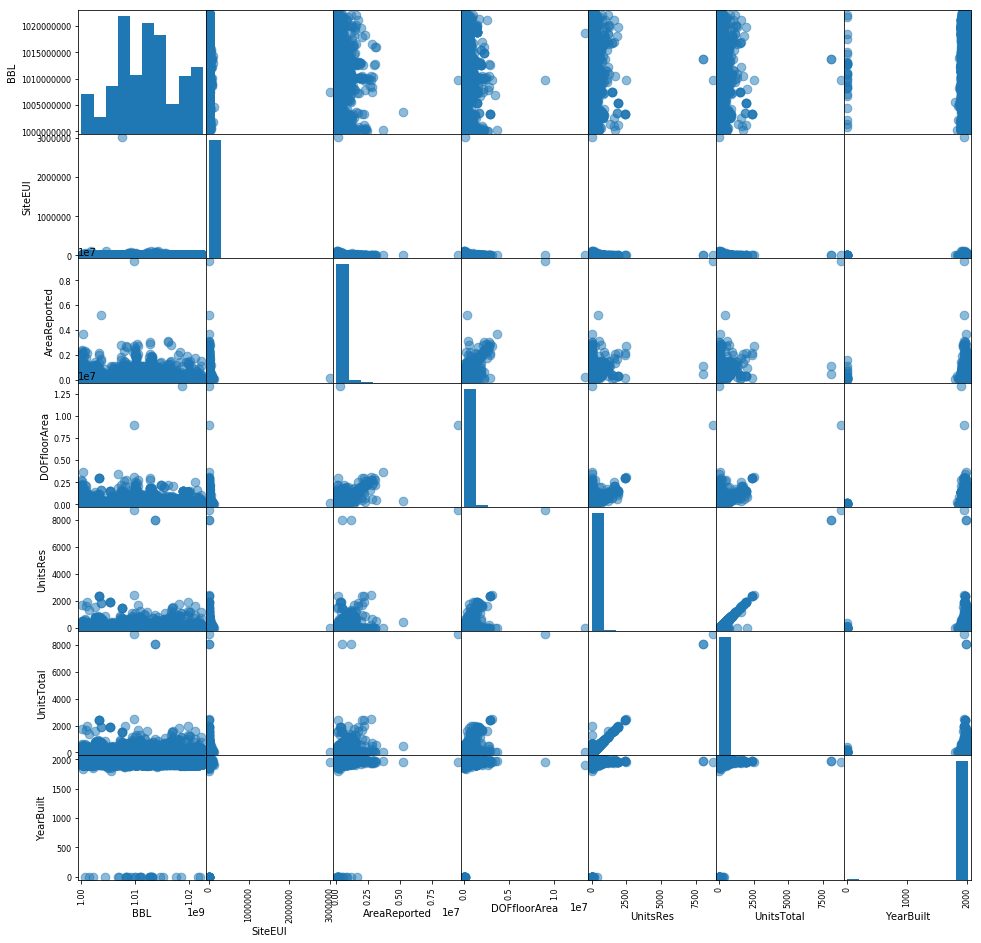

In [21]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (mergedata, s=300, figsize=(16, 16))


The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them.

In [22]:
mergedata['EnergyTOTAL']=mergedata.SiteEUI*mergedata.AreaReported

Text(0,0.5,'Total Number of Units')

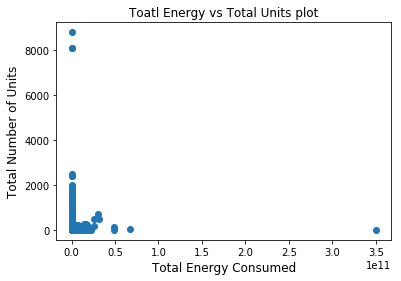

In [23]:
pl.scatter(mergedata.EnergyTOTAL,mergedata.UnitsTotal)
pl.title('Toatl Energy vs Total Units plot')
pl.xlabel('Total Energy Consumed',fontsize=12)
pl.ylabel('Total Number of Units', fontsize=12)

(1, 1000)

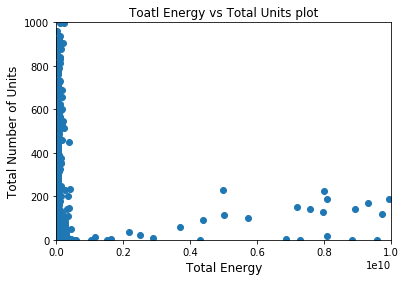

In [24]:
pl.scatter(mergedata.EnergyTOTAL,mergedata.UnitsTotal)
pl.title('Toatl Energy vs Total Units plot')
pl.xlabel('Total Energy',fontsize=12)
pl.ylabel('Total Number of Units', fontsize=12)
pl.xlim(1,1e10)
pl.ylim(1,1000)

#### Creating a dataset by removing the outliers

In [25]:
datacut= mergedata[(mergedata.EnergyTOTAL>0) & (mergedata.UnitsTotal>10) & (mergedata.UnitsTotal<1000)]

In [26]:
datacut.dropna()
datacut.head()

,BBL,SiteEUI,AreaReported,DOFfloorArea,UnitsRes,UnitsTotal,YearBuilt,EnergyTOTAL
2,1.013110e+09,125.4,330000.0,313200.0,0,56,1977,41382000.0
16,1.008150e+09,117.0,364000.0,364000.0,0,24,1954,42588000.0
18,1.005050e+09,82.1,235370.0,214110.0,0,24,1926,19323877.0
19,1.021420e+09,137.7,64806.0,64816.0,54,62,1924,8923786.2
20,1.021750e+09,103.2,62839.0,62847.0,75,85,1920,6484984.8


(100000.0, 10000000000.0)

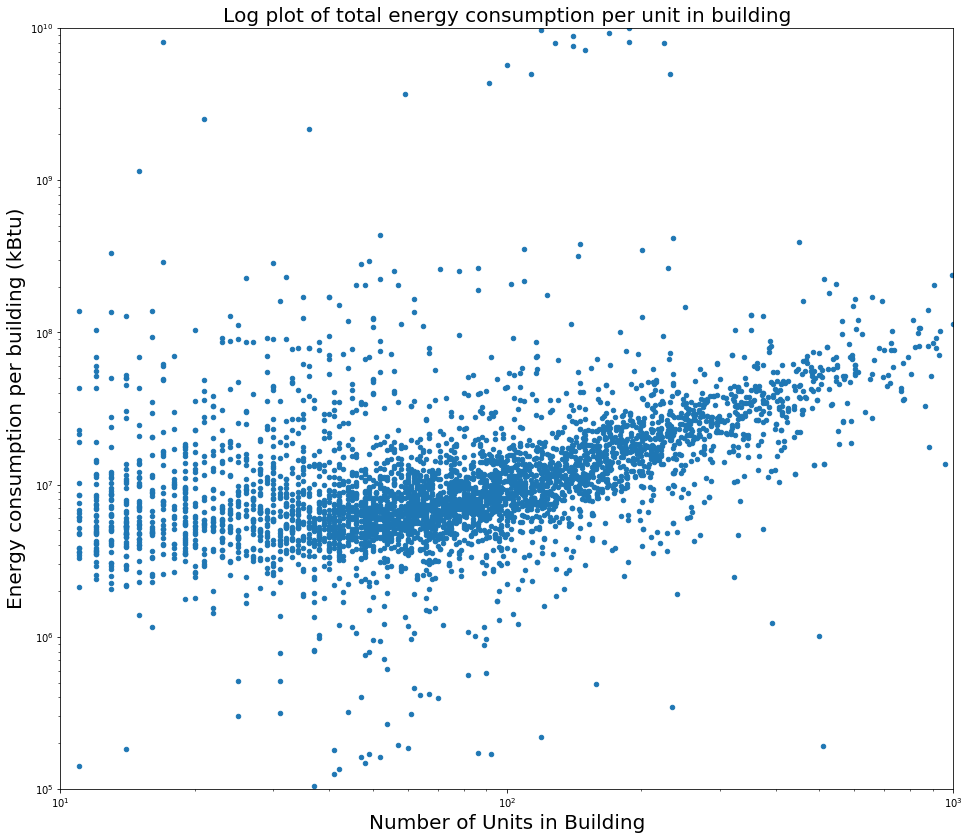

In [27]:
ax = datacut.plot(kind='scatter', y='EnergyTOTAL', x='UnitsTotal', 
                   marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
ax.set_title('Log plot of total energy consumption per unit in building',fontsize=20)
ax.set_xlim(10,10e2)
ax.set_ylim(10e4,10e9)

## Fitting Line

In [45]:
## TotalUnits Vs TotalEnergyConsumed

x=datacut.UnitsTotal
y=datacut.EnergyTOTAL
X = sm.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), X,missing='drop').fit()
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            EnergyTOTAL   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     846.1
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          8.60e-170
Time:                        15:03:17   Log-Likelihood:                -2570.3
No. Observations:                4251   AIC:                             5145.
Df Residuals:                    4249   BIC:                             5157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.0800      0.033    181.537      0.000         6.014     6.146
UnitsTotal     0.5044      0.017     29.087      0.000         0.470     0.538
==============================================================================
Omnibus:                     2284.377   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45410.613
Skew:                           2.123   Prob(JB):                         0.00
Kurtosis:                      18.438   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'Log Plot of number of units vs Energy consumed with fitted line')

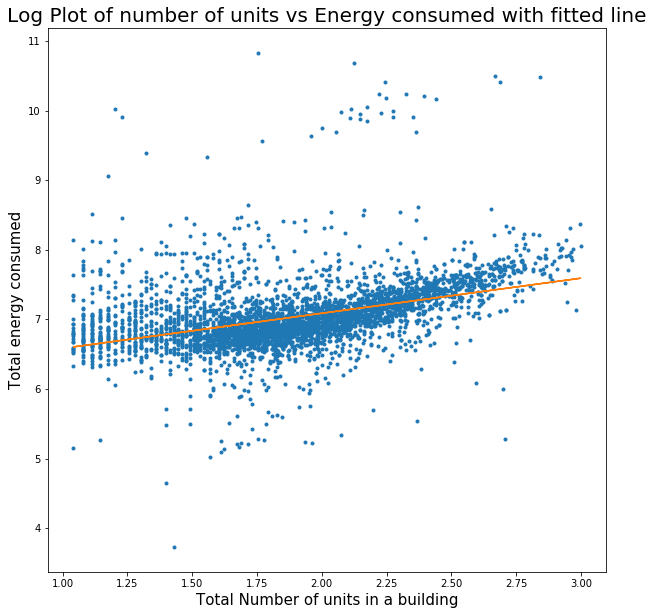

In [29]:
pl.figure(figsize=(10,10))
pl.plot(np.log10(datacut.UnitsTotal),np.log10(datacut.EnergyTOTAL),'.')

pl.plot(np.log10(datacut.UnitsTotal),linmodel.predict())

pl.xlabel('Total Number of units in a building',fontsize=15)
pl.ylabel('Total energy consumed',fontsize=15)
pl.title('Log Plot of number of units vs Energy consumed with fitted line',fontsize=20)

In [46]:
## TotalEnergyConsumed vs TotalUnits

x=datacut.EnergyTOTAL
y=datacut.UnitsTotal
X = sm.add_constant(np.log10(x))
linmodel2 = sm.OLS(np.log10(y), X,missing='drop').fit()
linmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     846.1
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          8.60e-170
Time:                        15:03:40   Log-Likelihood:                -1663.6
No. Observations:                4251   AIC:                             3331.
Df Residuals:                    4249   BIC:                             3344.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.4245      0.080     -5.319      0.000        -0.581    -0.268
EnergyTOTAL     0.3292      0.011     29.087      0.000         0.307     0.351
==============================================================================
Omnibus:                      126.654   Durbin-Watson:                   1.373
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.940
Skew:                          -0.425   Prob(JB):                     1.11e-30
Kurtosis:                       3.239   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5,1,'Log Plot of Energy consumed vs number of units with fitted line')

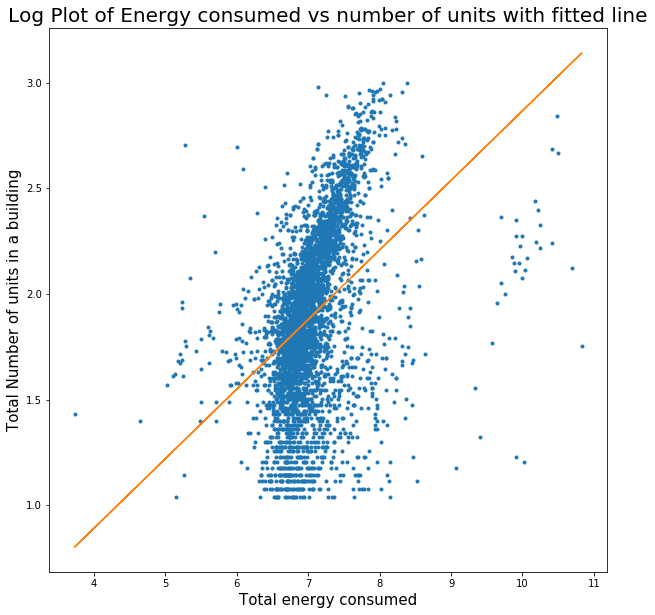

In [31]:
pl.figure(figsize=(10,10))
pl.plot(np.log10(datacut.EnergyTOTAL),np.log10(datacut.UnitsTotal),'.')

pl.plot(np.log10(datacut.EnergyTOTAL),linmodel2.predict(),'-')

pl.xlabel('Total energy consumed',fontsize=15)
pl.ylabel('Total Number of units in a building',fontsize=15)
pl.title('Log Plot of Energy consumed vs number of units with fitted line',fontsize=20)

In [32]:

def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.sqrt(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((model - data)**2) / errors**2).sum()
    else: 
        print ('''ERROR:must pass arrays of identical dimension for data, model and (optional) error)''')
        return -1

In [33]:
errorsU=chi2(data=datacut.UnitsTotal,model=linmodel2.predict())

In [34]:
errorsU

485199.28523513768

In [35]:
errorsE=chi2(data=datacut.EnergyTOTAL,model=linmodel.predict())

In [36]:
errorsE

533694261996.76569

In [37]:
if errorsU>errorsE:
    print('As the chi square value of model measuring Total energy against total units has more errors.')
else:
    print('As the chi square value of model measuring Total units against total energy has more errors.')

As the chi square value of model measuring Total units against total energy has more errors.


## 2nd degree Polynomial

In [38]:
df = pd.DataFrame({'x': np.log10(datacut.UnitsTotal), 'y': np.log10(datacut.EnergyTOTAL)})
df['x2'] = df.x**2
df.head()

,x,y,x2
2,1.748188,7.616811,3.056161
16,1.380211,7.629287,1.904983
18,1.380211,7.286094,1.904983
19,1.792392,6.950549,3.212668
20,1.929419,6.811909,3.722657


In [39]:
linefit = np.arange(np.log10(datacut.UnitsTotal).min(), np.log10(datacut.EnergyTOTAL).max(), 0.01)
polyfit = pd.DataFrame({'x': linefit, 'x2': linefit**2})
len(polyfit)

979

In [40]:
poly_fit=smf.ols(formula='y~ x + x2',data=df).fit()

In [41]:
poly_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     614.2
Date:                Mon, 23 Oct 2017   Prob (F-statistic):          5.05e-235
Time:                        15:00:09   Log-Likelihood:                -2416.4
No. Observations:                4251   AIC:                             4839.
Df Residuals:                    4248   BIC:                             4858.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.1126      0.118     68.578      0.000         7.881     8.345
x             -1.7096      0.125    -13.668      0.000        -1.955    -1.464
x2             0.5776      0.032     17.861      0.000         0.514     0.641
==============================================================================
Omnibus:                     2429.800   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59213.595
Skew:                           2.246   Prob(JB):                         0.00
Kurtosis:                      20.724   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(2, 14)

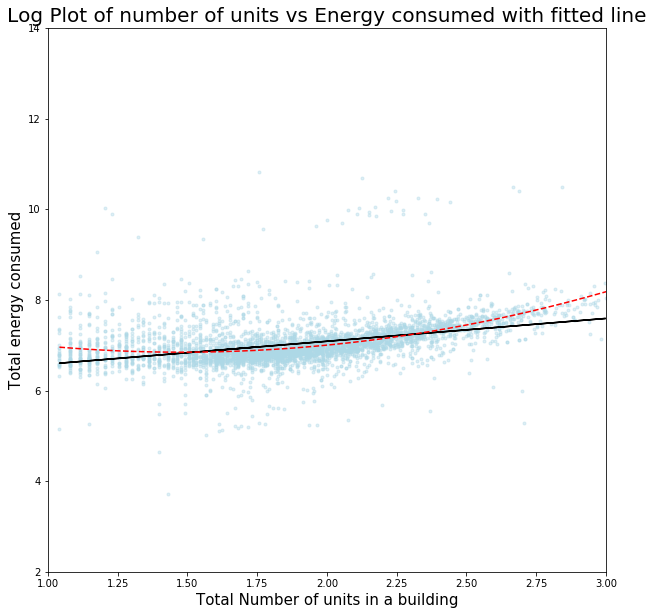

In [42]:
pl.figure(figsize=(10,10))
pl.plot(np.log10(datacut.UnitsTotal),np.log10(datacut.EnergyTOTAL),'.',color='lightblue',alpha=0.4)

pl.plot(np.log10(datacut.UnitsTotal),linmodel.predict(),color='black')

pl.plot(linefit, poly_fit.predict(sm.add_constant(polyfit)), 'r--')

pl.xlabel('Total Number of units in a building',fontsize=15)
pl.ylabel('Total energy consumed',fontsize=15)
pl.title('Log Plot of number of units vs Energy consumed with fitted line',fontsize=20)
pl.xlim(1,3)
pl.ylim(2,14)

In [43]:
print('Log Likelihood Ratio:', -2* (-linmodel.llf - (-poly_fit.llf)))
print('Likelihood ratio from statsmodel', poly_fit.compare_lr_test(linmodel)[0])

Log Likelihood Ratio: -307.810248996
Likelihood ratio from statsmodel 307.810248996


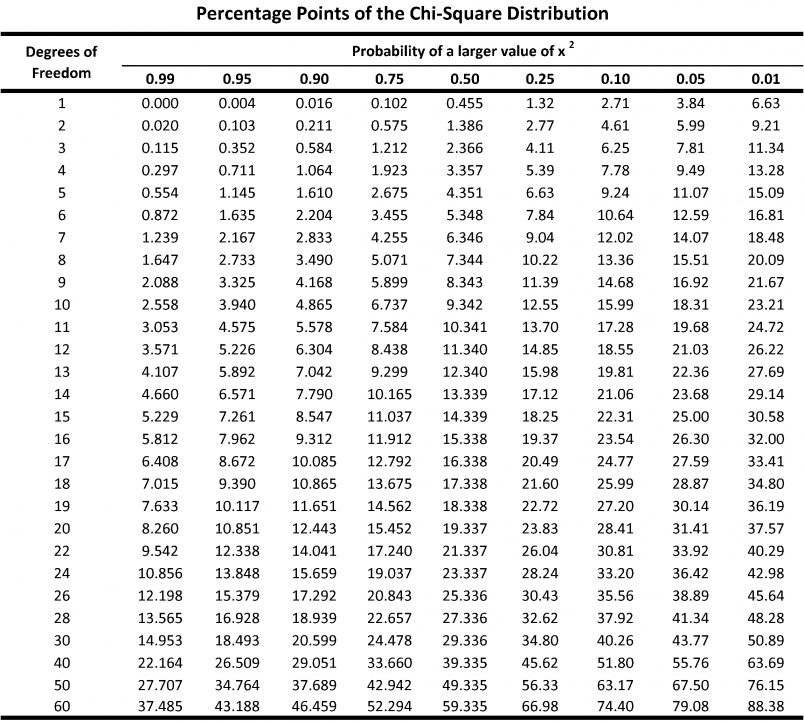

In [44]:
from IPython.display import Image
Image('http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG')

Chi square value for 1 degree of freedom is 3.84 which is very small than the log likelihood ratio we got. Therefore we can say polynomial model is better than the linear model.